In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import os
import tensorflow as tf
import env  

print(tf.__version__)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))



2024-10-18 22:58:50.130969: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-18 22:58:50.143968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 22:58:50.158369: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 22:58:50.162750: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 22:58:50.173395: I tensorflow/core/platform/cpu_feature_guar

2.17.0
Num GPUs Available:  1


In [6]:
import utils.data as dl

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)) 
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  

])


# read data
train_df = pd.read_csv('train.csv')  
test_df = pd.read_csv('test.csv')

class CustomImageDatasetTrain(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, str(self.dataframe.iloc[idx, 0]) + '.jpg')
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 6]

        stable_height = self.dataframe.iloc[idx]['stable_height']
        total_height = self.dataframe.iloc[idx]['total_height']
        
        if self.transform:
            image = self.transform(image)
        return image, label

class CustomImageDatasetTest(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, str(self.dataframe.iloc[idx, 0]) + '.jpg')
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        return image, label
# split dataset to 2:8
train_size = int(0.8 * len(train_df))
val_size = len(train_df) - train_size
# random sampling
train_df_split = train_df.sample(n=train_size, random_state=42)
val_df_split = train_df.drop(train_df_split.index)

train_dataset = CustomImageDatasetTrain(dataframe=train_df_split, img_dir='train', transform=train_transform)
val_dataset = CustomImageDatasetTrain(dataframe=val_df_split, img_dir='train', transform=test_transform)
test_dataset = CustomImageDatasetTest(dataframe=test_df, img_dir='test', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
def print_train_loader_info(train_loader):

    total_samples = len(train_loader.dataset)

    batch_size = train_loader.batch_size

    total_batches = len(train_loader)

    print(f"Total samples in train_loader: {total_samples}")
    print(f"Batch size: {batch_size}")
    print(f"Total batches: {total_batches}")
print_train_loader_info(train_loader)

Total samples in train_loader: 6144
Batch size: 32
Total batches: 192


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import os

class ResNetConfig:
    def __init__(self,model_name='resnet50'):

        self.model_name = model_name  
        self.pretrained = True
        self.freeze_encoder = False
        self.hidden_dim = 1024
        self.dropout = 0.5
        self.output_dim = 1  # output a single value


        self.lr = 1e-4
        self.epochs = 15
        self.batch_size = 32
        self.step_size = 10  # Step size for the learning rate scheduler
        self.gamma = 0.1  
        self.loss_fn = nn.SmoothL1Loss()  # Loss function, using Smooth L1 Loss,base loss

        self.image_size = (245, 200)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResNetModel(nn.Module):
    def __init__(self, config):
        super(ResNetModel, self).__init__()

        if config.model_name == 'resnet50':
            self.base_model = models.resnet50(pretrained=config.pretrained)
        elif config.model_name == 'googlenet':
            self.base_model = models.googlenet(pretrained=config.pretrained)
        elif config.model_name == 'inception_v3':
            self.base_model = models.inception_v3(pretrained=config.pretrained, aux_logits=True)
        elif config.model_name == 'mobilenet_v2':
            self.base_model = models.mobilenet_v2(pretrained=config.pretrained)
        elif config.model_name == 'densenet121':
            self.base_model = models.densenet121(pretrained=config.pretrained)
        elif config.model_name == 'vgg16':
            self.base_model = models.vgg16(pretrained=config.pretrained)
        else:
            raise ValueError(f"Unsupported model: {config.model_name}")

        # freeze encoder if needed
        if config.freeze_encoder:
            for param in self.base_model.parameters():
                param.requires_grad = False


        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_ftrs, config.hidden_dim),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_dim, config.output_dim)
        )

    def forward(self, x):
        return self.base_model(x)

def approximate_accuracy(outputs, labels, tolerance=1.0):

    preds = torch.round(outputs.squeeze()) 
    correct = torch.abs(preds - labels) <= tolerance  
    return correct.sum().item()

# calculate exact accuracy 
def exact_accuracy(outputs, labels):
    
    preds = torch.round(outputs.squeeze())  
    correct = torch.abs(preds - labels) <= 0  
    return correct.sum().item()
def train(model, train_loader, val_loader, config, optimizer, scheduler):
    model = model.to(config.device)  
    epoch_results = [] 

    for epoch in range(config.epochs):
        model.train()
        running_loss = 0.0
        correct_exact = 0
        correct_approx = 0
        total = 0

        print(f"\nEpoch {epoch + 1}/{config.epochs}")

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{config.epochs}", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(config.device), labels.to(config.device)

            optimizer.zero_grad()  
            outputs = model(inputs)  
            loss = config.loss_fn(outputs.squeeze(), labels.float())  
            loss.backward() 
            optimizer.step()  

            running_loss += loss.item()
            total += labels.size(0)
            correct_exact += exact_accuracy(outputs, labels)  
            correct_approx += approximate_accuracy(outputs, labels)  

            progress_bar.set_postfix(loss=loss.item())

        scheduler.step()  


        train_loss = running_loss / len(train_loader)
        train_exact_acc = correct_exact / total
        train_approx_acc = correct_approx / total
        print(f"Epoch {epoch + 1} Train Loss: {train_loss:.4f} | Exact Acc: {train_exact_acc:.4f} | Approx Acc: {train_approx_acc:.4f}")

        # validating phase
        val_results = evaluate(model, val_loader, config)
        print(f"Epoch {epoch + 1} Validation Loss: {val_results['val_loss']:.4f} | Val Exact Acc: {val_results['val_exact_acc']:.4f} | Val Approx Acc: {val_results['val_approx_acc']:.4f}")

        # store results
        epoch_results.append({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_exact_acc": train_exact_acc,
            "train_approx_acc": train_approx_acc,
            "val_loss": val_results['val_loss'],
            "val_exact_acc": val_results['val_exact_acc'],
            "val_approx_acc": val_results['val_approx_acc']
        })

    return epoch_results  


def evaluate(model, val_loader, config):
    model.eval()  
    running_loss = 0.0
    correct_exact = 0
    correct_approx = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(config.device), labels.to(config.device)
            outputs = model(inputs)
            loss = config.loss_fn(outputs.squeeze(), labels.float())
            running_loss += loss.item()

            total += labels.size(0)
            correct_exact += exact_accuracy(outputs, labels)  
            correct_approx += approximate_accuracy(outputs, labels)  


    val_loss = running_loss / len(val_loader)
    val_exact_acc = correct_exact / total
    val_approx_acc = correct_approx / total
   

    return {
        "val_loss": val_loss,
        "val_exact_acc": val_exact_acc,
        "val_approx_acc": val_approx_acc
    }



config = ResNetConfig(model_name='googlenet')



model = ResNetModel(config)

# Define optimizer and learning rate scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.lr)
scheduler = StepLR(optimizer, step_size=config.step_size, gamma=config.gamma)


epoch_results = train(model, train_loader, val_loader, config, optimizer, scheduler)
import json

def save_results_to_json(epoch_results, filename="resnet50_result.json"):

    with open(filename, "w") as f:
        json.dump(epoch_results, f, indent=4)
    print(f"Results saved to {filename}")
# save results
save_results_to_json(epoch_results, filename="googleNet_result.json")



/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/15


Epoch 1 Train Loss: 0.8080 | Exact Acc: 0.2544 | Approx Acc: 0.6724
Epoch 1 Validation Loss: 0.6376 | Val Exact Acc: 0.3242 | Val Approx Acc: 0.7513

Epoch 2/15


Epoch 2 Train Loss: 0.6441 | Exact Acc: 0.3107 | Approx Acc: 0.7453
Epoch 2 Validation Loss: 0.6258 | Val Exact Acc: 0.3184 | Val Approx Acc: 0.7552

Epoch 3/15


Epoch 3 Train Loss: 0.5958 | Exact Acc: 0.3486 | Approx Acc: 0.7708
Epoch 3 Validation Loss: 0.6065 | Val Exact Acc: 0.3490 | Val Approx Acc: 0.7539

Epoch 4/15


Epoch 4 Train Loss: 0.5655 | Exact Acc: 0.3688 | Approx Acc: 0.7824
Epoch 4 Validation Loss: 0.5831 | Val Exact Acc: 0.3613 | Val Approx Acc: 0.7780

Epoch 5/15


Epoch 5 Train Loss: 0.5443 | Exact Acc: 0.3864 | Approx Acc: 0.7925
Epoch 5 Validation Loss: 0.5837 | Val Exact Acc: 0.3835 | Val Approx Acc: 0.7773

Epoch 6/15


Epoch 6 Train Loss: 0.5305 | Exact Acc: 0.3939 | Approx Acc: 0.8037
Epoch 6 Validation Loss: 0.5780 | Val Exact Acc: 0.3802 | Val Approx Acc: 0.7878

Epoch 7/15


Epoch 7 Train Loss: 0.5158 | Exact Acc: 0.4085 | Approx Acc: 0.8083
Epoch 7 Validation Loss: 0.5939 | Val Exact Acc: 0.3776 | Val Approx Acc: 0.7715

Epoch 8/15


Epoch 8 Train Loss: 0.5059 | Exact Acc: 0.4098 | Approx Acc: 0.8136
Epoch 8 Validation Loss: 0.5753 | Val Exact Acc: 0.3854 | Val Approx Acc: 0.7858

Epoch 9/15


Epoch 9 Train Loss: 0.4884 | Exact Acc: 0.4312 | Approx Acc: 0.8237
Epoch 9 Validation Loss: 0.5587 | Val Exact Acc: 0.3978 | Val Approx Acc: 0.7793

Epoch 10/15


Epoch 10 Train Loss: 0.4744 | Exact Acc: 0.4372 | Approx Acc: 0.8289
Epoch 10 Validation Loss: 0.5595 | Val Exact Acc: 0.4147 | Val Approx Acc: 0.7884

Epoch 11/15


Epoch 11 Train Loss: 0.4428 | Exact Acc: 0.4574 | Approx Acc: 0.8428
Epoch 11 Validation Loss: 0.5484 | Val Exact Acc: 0.4225 | Val Approx Acc: 0.7897

Epoch 12/15


Epoch 12 Train Loss: 0.4385 | Exact Acc: 0.4601 | Approx Acc: 0.8421
Epoch 12 Validation Loss: 0.5480 | Val Exact Acc: 0.4206 | Val Approx Acc: 0.7884

Epoch 13/15


Epoch 13 Train Loss: 0.4205 | Exact Acc: 0.4722 | Approx Acc: 0.8555
Epoch 13 Validation Loss: 0.5490 | Val Exact Acc: 0.4264 | Val Approx Acc: 0.7858

Epoch 14/15


Epoch 14 Train Loss: 0.4226 | Exact Acc: 0.4697 | Approx Acc: 0.8517
Epoch 14 Validation Loss: 0.5509 | Val Exact Acc: 0.4297 | Val Approx Acc: 0.7832

Epoch 15/15


Epoch 15 Train Loss: 0.4274 | Exact Acc: 0.4704 | Approx Acc: 0.8538
Epoch 15 Validation Loss: 0.5471 | Val Exact Acc: 0.4238 | Val Approx Acc: 0.7884
Results saved to resnet50_result.json


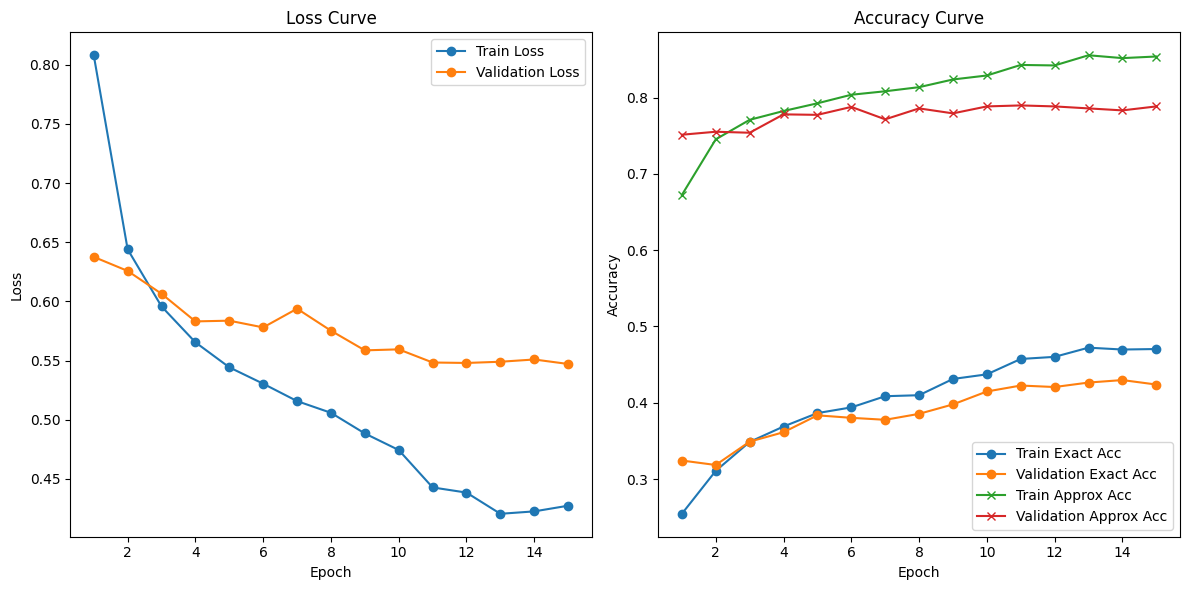

In [9]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(epoch_results):

    epochs = [res["epoch"] for res in epoch_results]
    train_loss = [res["train_loss"] for res in epoch_results]
    val_loss = [res["val_loss"] for res in epoch_results]
    train_exact_acc = [res["train_exact_acc"] for res in epoch_results]
    val_exact_acc = [res["val_exact_acc"] for res in epoch_results]
    train_approx_acc = [res["train_approx_acc"] for res in epoch_results]
    val_approx_acc = [res["val_approx_acc"] for res in epoch_results]

    # plot loss figure
    plt.figure(figsize=(12, 6))
    

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_exact_acc, label='Train Exact Acc', marker='o')
    plt.plot(epochs, val_exact_acc, label='Validation Exact Acc', marker='o')
    plt.plot(epochs, train_approx_acc, label='Train Approx Acc', marker='x')
    plt.plot(epochs, val_approx_acc, label='Validation Approx Acc', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_from_json(json_file):

    with open(json_file, "r") as f:
        epoch_results = json.load(f)


    plot_loss_and_accuracy(epoch_results)


plot_from_json("googleNet_result.json")


In [11]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm

model.eval()

predictions = []

with torch.no_grad():
    for inputs, _ in tqdm(test_loader, desc="Predicting"):
        inputs = inputs.to("cuda")

        outputs = model(inputs).squeeze()

        preds = outputs.cpu().numpy().tolist()

        rounded_preds = [int(round(p)) for p in preds]

        predictions.extend(rounded_preds)

# Combine the results with the original DataFrame's filenames
result = pd.DataFrame({
    "id": test_dataset.dataframe.iloc[:, 0],  
    "stable_height": predictions  
})


print(result.head())


result.to_csv("predictions.csv", index=False)


Predicting: 100%|██████████| 60/60 [00:03<00:00, 17.50it/s]

     id  stable_height
0    95              5
1   706              2
2  2854              1
3  3093              3
4  4283              3
